In [1]:
import numpy as np

In [2]:
import pymc4 as pm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
config = tf.ConfigProto()

In [4]:
config.graph_options.optimizer_options.global_jit_level = (
    tf.OptimizerOptions.ON_1)
config.intra_op_parallelism_threads = 1
config.inter_op_parallelism_threads = 1

In [5]:
sess = tf.InteractiveSession(config=config)

## Forward Sampling

In [5]:
@pm.model
def mixture(n_groups, n_points):    
    centers = pm.Normal('centers', loc=tf.zeros((n_groups, 2)), scale=1)
    scales = pm.HalfNormal('scales', 0.4 * tf.ones(n_groups))
    rates = pm.Dirichlet('rates', concentration=tf.ones(n_groups))
    
    group_assignments = pm.Multinomial('group_assignments', total_count=n_points, probs=rates)
    
    for idx in range(n_groups):
        count = tf.to_int32(group_assignments[idx])
        pm.Normal(f'group_{idx}', loc=centers[idx] * tf.ones((count, 2)), scale=scales[idx])
    
    
model = mixture.configure(n_groups=5, n_points=10_000)

[0.60691094 0.15599424 0.1356018  0.05962308 0.0418699 ]


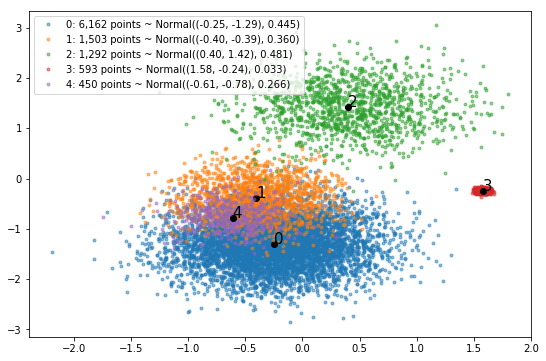

In [6]:
forward_sample = sess.run(model.forward_sample())

centers = forward_sample['centers']
scales = forward_sample['scales']
group_assignments = forward_sample['group_assignments']

fig, ax = plt.subplots(figsize=(9, 6))

for idx, (center, scale, count) in enumerate(zip(centers, scales, group_assignments)):
    group = forward_sample[f'group_{idx}']
    center_str = ', '.join(f'{c:.2f}' for c in center)
    label = f'{idx}: {int(count):,d} points ~ Normal(({center_str}), {scale:.3f})'
    ax.plot(group[:, 0], group[:, 1], '.', alpha=0.5, label=label)
    ax.plot(center[0], center[1], 'ko')
    ax.text(center[0], center[1], str(idx), size=15)

ax.legend();
print(forward_sample['rates'])

## Graph

In [7]:
@pm.model
def t_test(sd_prior='half_normal'):
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd', 1)
    pm.Normal('y_0', 0, 2 * sd)
    pm.Normal('y_1', mu, 2 * sd)

model = t_test.configure()

model._forward_context.vars

In [9]:
func = model.make_log_prob_function()

In [10]:
mu = tf.placeholder(tf.float32)
sd = tf.placeholder(tf.float32)
y_0 = tf.placeholder(tf.float32)
y_1 = tf.placeholder(tf.float32)
logp = func(mu, sd, y_0, y_1)

mu_ = np.ones(10).astype('f')
sd_ = np.ones(10).astype('f')
y_0_ = np.ones(10).astype('f')
y_1_ = np.ones(10).astype('f')
%timeit sess.run(logp, feed_dict={mu: mu_, sd: sd_, y_0: y_0_, y_1: y_1_})
sess.run(logp, feed_dict={mu: mu_, sd: sd_, y_0: y_0_, y_1: y_1_})

252 µs ± 7.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


-54.939014

In [11]:
grad = tf.gradients(logp, [mu, sd, y_0, y_1])
%timeit sess.run([logp, grad], feed_dict={mu: mu_, sd: sd_, y_0: y_0_, y_1: y_1_})
sess.run([logp, grad], feed_dict={mu: mu_, sd: sd_, y_0: y_0_, y_1: y_1_})

592 µs ± 111 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


[-54.939014,
 [array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float32),
  array([-2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75,
         -2.75], dtype=float32),
  array([-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25,
         -0.25], dtype=float32),
  array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.], dtype=float32)]]

In [12]:
array = tf.placeholder(tf.float32)

mu = array[:10]
sd = array[10:20]
y_0 = array[20:30]
y_1 = array[30:40]
logp = func(mu, sd, y_0, y_1)

array_ = np.ones(40).astype('f')
%timeit sess.run(logp, {array: array_})
sess.run(logp, {array: array_})

169 µs ± 2.84 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


-54.939014

In [13]:
grad = tf.gradients(logp, array)
%timeit sess.run([logp, grad], {array: array_})
sess.run([logp, grad], {array: array_})

415 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


[-54.939014,
 [array([-1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  ,
         -1.  , -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75,
         -2.75, -2.75, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25,
         -0.25, -0.25, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ], dtype=float32)]]

In [14]:
mu = tf.Variable(tf.ones(10), dtype=tf.float32)[:]
sd = tf.Variable(tf.ones(10), dtype=tf.float32)[:]
y_0 = tf.Variable(tf.ones(10), dtype=tf.float32)[:]
y_1 = tf.Variable(tf.ones(10), dtype=tf.float32)[:]
logp = func(mu, sd, y_0, y_1)

sess.run(tf.global_variables_initializer())
%timeit sess.run(logp)
sess.run(logp)

121 µs ± 8.89 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


-54.939014

In [15]:
array = tf.Variable(tf.ones(40), dtype=tf.float32)
grad_array = tf.Variable(tf.zeros([1, 40]), dtype=tf.float32)

mu = array[:10]
sd = array[10:20]
y_0 = array[20:30]
y_1 = array[30:40]
logp = func(mu, sd, y_0, y_1)
grad = tf.gradients(logp, array)
write = grad_array.assign(grad, read_value=False)

sess.run(tf.global_variables_initializer())

%timeit sess.run([logp, write])
sess.run([logp, write])

232 µs ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


[-54.939014, None]

In [16]:
%timeit sess.run([logp, write])
sess.run([logp, write])

213 µs ± 33.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


[-54.939014, None]

In [17]:
array = tf.Variable(tf.ones(40), dtype=tf.float32)
grad_array = tf.Variable(tf.zeros([1, 40]), dtype=tf.float32)

def logp_wrapper():
    mu = array[:10]
    sd = array[10:20]
    y_0 = array[20:30]
    y_1 = array[30:40]
    logp = func(mu, sd, y_0, y_1)
    grad = tf.gradients(logp, array)
    write = grad_array.assign(grad, read_value=False)
    
    return logp, write

In [18]:
def logp_wrapper_xla():
    logp, grad = xla.compile(logp_wrapper, inputs=[])
    return logp, grad

In [19]:
logp, write = logp_wrapper()

In [20]:
sess.run(tf.global_variables_initializer())

%timeit sess.run([logp, write])
sess.run([logp, write])

209 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


[-54.939014, None]

## Eager

In [2]:
tf.enable_eager_execution()

In [3]:
@pm.model
def t_test(sd_prior='half_normal'):
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd', 1)
    pm.Normal('y_0', 0, 2 * sd)
    pm.Normal('y_1', mu, 2 * sd)

model = t_test.configure()

model._forward_context.vars

In [4]:
func = model.make_logp_function()

mu = tf.ones((10,))
sd = tf.ones((10,))
y_0 = tf.ones((10,))
y_1 = tf.ones((10,))
%timeit logp = func(mu, sd, y_0, y_1)
func(mu, sd, y_0, y_1)

1.31 ms ± 6.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<tf.Tensor: id=519232, shape=(), dtype=float32, numpy=-54.939014>

In [5]:
logp_func_defun = tf.contrib.eager.defun(func)

In [6]:
mu = tf.ones((10,))
sd = tf.ones((10,))
y_0 = tf.ones((10,))
y_1 = tf.ones((10,))
%timeit logp = logp_func_defun(mu, sd, y_0, y_1)
logp_func_defun(mu, sd, y_0, y_1)

194 µs ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<tf.Tensor: id=600435, shape=(), dtype=float32, numpy=-54.939014>

In [7]:
mu = tf.ones((10,))
sd = tf.ones((10,))
y_0 = tf.ones((10,))
y_1 = tf.ones((10,))

with tf.GradientTape() as tape:
    tape.watch(mu)
    tape.watch(sd)
    tape.watch(y_0)
    tape.watch(y_1)

    logp = logp_func_defun(mu, sd, y_0, y_1)

tape.gradient(logp, mu)

<tf.Tensor: id=600739, shape=(10,), dtype=float32, numpy=array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>

In [8]:
%%timeit
with tf.GradientTape() as tape:
    tape.watch(mu)
    tape.watch(sd)
    tape.watch(y_0)
    tape.watch(y_1)
    logp = logp_func_defun(mu, sd, y_0, y_1)

tape.gradient(logp, [mu, sd, y_0, y_1])

646 µs ± 81.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
def logp_and_grad(*args):
    logp = func(*args)
    return logp, tf.gradients(logp, args)

logp_grad_func_defun = tf.contrib.eager.defun(logp_and_grad)

mu = tf.ones((10,))
sd = tf.ones((10,))
y_0 = tf.ones((10,))
y_1 = tf.ones((10,))
%timeit logp = logp_grad_func_defun(mu, sd, y_0, y_1)
logp_grad_func_defun(mu, sd, y_0, y_1)

370 µs ± 56 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


(<tf.Tensor: id=876881, shape=(), dtype=float32, numpy=-54.939014>,
 [<tf.Tensor: id=876882, shape=(10,), dtype=float32, numpy=array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>,
  <tf.Tensor: id=876883, shape=(10,), dtype=float32, numpy=
  array([-2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75,
         -2.75], dtype=float32)>,
  <tf.Tensor: id=876884, shape=(10,), dtype=float32, numpy=
  array([-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25,
         -0.25], dtype=float32)>,
  <tf.Tensor: id=876885, shape=(10,), dtype=float32, numpy=array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.], dtype=float32)>])

In [36]:
from tensorflow.contrib.compiler import xla

In [42]:
array = tf.ones(40)

#@tf.contrib.eager.defun
def logp_wrapper(array):
    mu = array[:10]
    sd = array[10:20]
    y_0 = array[20:30]
    y_1 = array[30:40]
    logp = func(mu, sd, y_0, y_1)
    grad = tf.gradients(logp, array)
    return logp, grad

@tf.contrib.eager.defun
def logp_wrapper_xla(array):
    logp, grad = xla.compile(logp_wrapper, inputs=[array])
    return logp, grad

logp_wrapper_xla(array)

/home/adr/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


NotFoundError: Function cluster_10478158696422980052 is not defined.
	Local lookup failed with: Function cluster_10478158696422980052 is not defined.
	 [[{{node cluster}} = XlaLaunch[Nresources=0, Targs=[DT_FLOAT], Tconstants=[], Tresults=[DT_FLOAT, DT_FLOAT], function=cluster_10478158696422980052[], _device="/job:localhost/replica:0/task:0/device:CPU:0"](placeholder, ^cluster/pivot)]] [Op:PartitionedCall]

In [35]:
%timeit logp_wrapper(array)

350 µs ± 49.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
import pymc3 as pm3

/anaconda3/envs/GSoC/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 36168 is still running
  # bpo-19612, bpo-30418: On Windows, stdin.write() fails
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/misc/cpucount.py:48: ResourceWarning: unclosed file <_io.TextIOWrapper name=59 encoding='UTF-8'>
  num = int(os.popen('sysctl -n hw.ncpu').read())
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/tests/main.py:6: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import NoseTester


In [ ]:
@pm.model
def t_test(sd_prior='half_normal'):
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd', 1)
    pm.Normal('y_0', 0, 2 * sd)
    pm.Normal('y_1', mu, 2 * sd)


In [24]:
with pm3.Model() as model:
    mu = pm3.Normal('mu', 0, 1, shape=10)
    sd = pm3.HalfNormal('sd', sd=1, transform=None, shape=10)
    pm3.Normal('y_0', 0, 2 * sd, shape=10)
    pm3.Normal('y_1', mu, 2 * sd, shape=10)

In [25]:
func_pm3 = model.logp_dlogp_function()

In [20]:
x0 = np.ones(func_pm3.size)

In [27]:
func_pm3.set_extra_values({})
%timeit func_pm3(x0)

39.3 µs ± 105 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
